In [2]:
import numpy as np
import pandas as pd
import os
import yfinance as yf
import matplotlib.pyplot as plt
import math
import datetime as dt
from datetime import datetime
from pandas.plotting import autocorrelation_plot

!pip install tensorflow
from sklearn.model_selection import train_test_split
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

In [4]:
import seaborn as sns

In [5]:
sns.set_style('whitegrid')
plt.style.use('ggplot')

In [6]:
data = yf.download('AAPL', start = '2015-02-01', end = '2023-08-01')
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-02-02,29.512501,29.792500,29.020000,29.657499,26.582630,250956400
2015-02-03,29.625000,29.772499,29.402500,29.662500,26.587107,207662800
2015-02-04,29.625000,30.127501,29.577499,29.889999,26.791023,280598800
2015-02-05,30.004999,30.057501,29.812500,29.985001,26.982241,168984800
2015-02-06,30.004999,30.062500,29.612499,29.732500,26.755026,174826400


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2015-02-02 to 2023-07-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2138 non-null   float64
 1   High       2138 non-null   float64
 2   Low        2138 non-null   float64
 3   Close      2138 non-null   float64
 4   Adj Close  2138 non-null   float64
 5   Volume     2138 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 116.9 KB


In [8]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2.138000e+03
mean,79.604193,80.504351,78.764017,79.675081,77.840598,1.258082e+08
std,52.785953,53.441039,52.188175,52.845197,53.286697,6.650040e+07
min,22.500000,22.917500,22.367500,22.584999,20.826063,3.145820e+07
25%,34.971876,35.251250,34.801250,35.026876,32.782167,8.154448e+07
50%,51.657499,52.161251,51.092501,51.808750,49.928894,1.081492e+08
75%,133.815006,135.049999,132.102501,133.669998,131.805157,1.501806e+08
max,196.059998,198.229996,195.259995,196.449997,196.185074,6.488252e+08


In [9]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
data.reset_index(drop = True, inplace=True)
data.fillna(data.mean , inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
0,29.512501,29.792500,29.020000,29.657499,26.582630,250956400
1,29.625000,29.772499,29.402500,29.662500,26.587107,207662800
2,29.625000,30.127501,29.577499,29.889999,26.791023,280598800
3,30.004999,30.057501,29.812500,29.985001,26.982241,168984800
4,30.004999,30.062500,29.612499,29.732500,26.755026,174826400


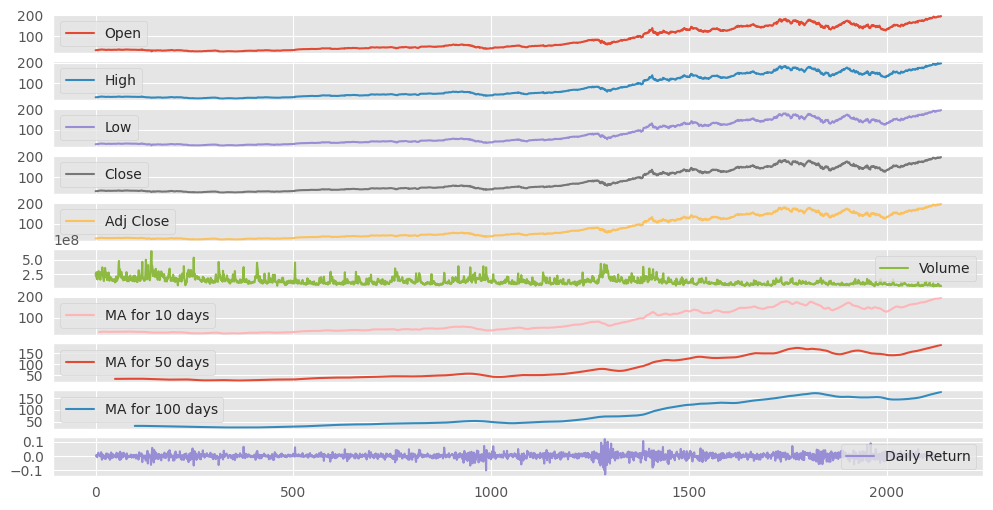

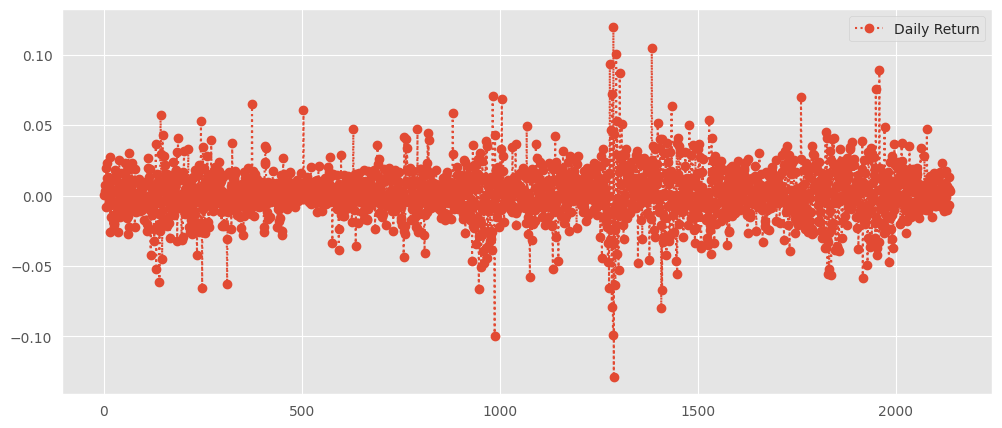

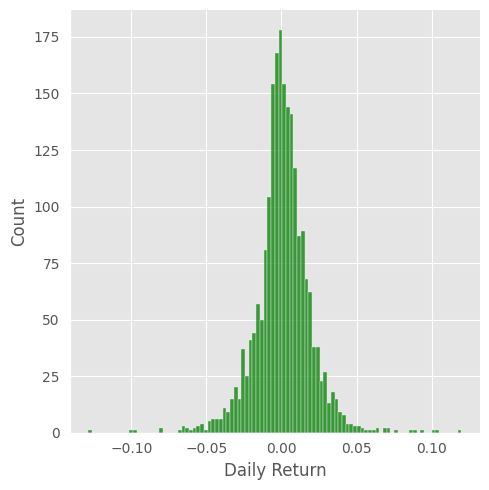

            Open        High         Low       Close   Adj Close     Volume  \
0      29.512501   29.792500   29.020000   29.657499   26.582630  250956400   
1      29.625000   29.772499   29.402500   29.662500   26.587107  207662800   
2      29.625000   30.127501   29.577499   29.889999   26.791023  280598800   
3      30.004999   30.057501   29.812500   29.985001   26.982241  168984800   
4      30.004999   30.062500   29.612499   29.732500   26.755026  174826400   
...          ...         ...         ...         ...         ...        ...   
2133  193.330002  194.440002  192.919998  193.619995  193.358887   37283200   
2134  193.669998  195.639999  193.320007  194.500000  194.237701   47471900   
2135  196.020004  197.199997  192.550003  193.220001  192.959427   47460200   
2136  194.669998  196.630005  194.139999  195.830002  195.565918   48291400   
2137  196.059998  196.490005  195.259995  196.449997  196.185074   38824100   

      MA for 10 days  MA for 50 days  MA for 100 da

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA for 10 days     0
MA for 50 days     0
MA for 100 days    0
Daily Return       0
dtype: int64

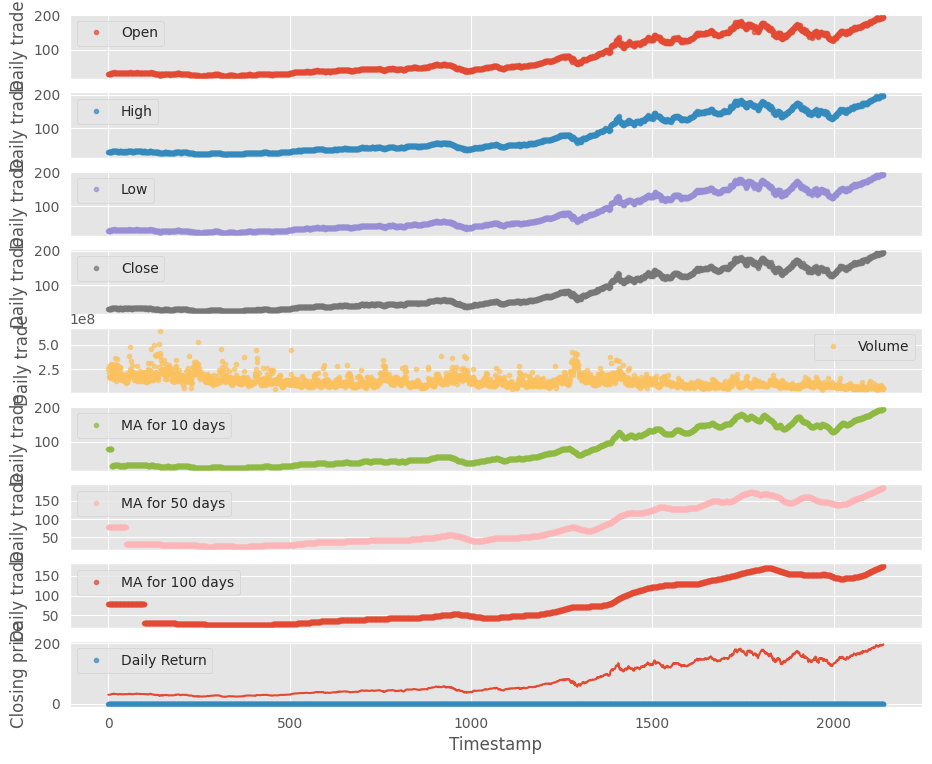

In [13]:
data.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()
#data['Close'].plot(legend=True, figsize = (12, 6))
#plt.show()
#data['Volume'].plot(legend=True,figsize=(12,7))
#plt.show()

data.shape
data.size
data.describe(include='all').T
data.dtypes
data.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

data['Daily Return'] = data['Close'].pct_change()
# plot the daily return percentage
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

sns.displot(data['Daily Return'].dropna(),bins=100,color='green')
plt.show()

date= pd.DataFrame(data.index)
closing_df1 = pd.DataFrame(data['Close'])
close1  = closing_df1.rename(columns={"Close": "data_close"})
close2=pd.concat([date,close1],axis=1)
close2.head()
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

data.nunique()

data.sort_index(axis=1,ascending=True)

cols_plot = ['Open', 'High', 'Low','Close','Volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = data[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

data.isnull().sum()

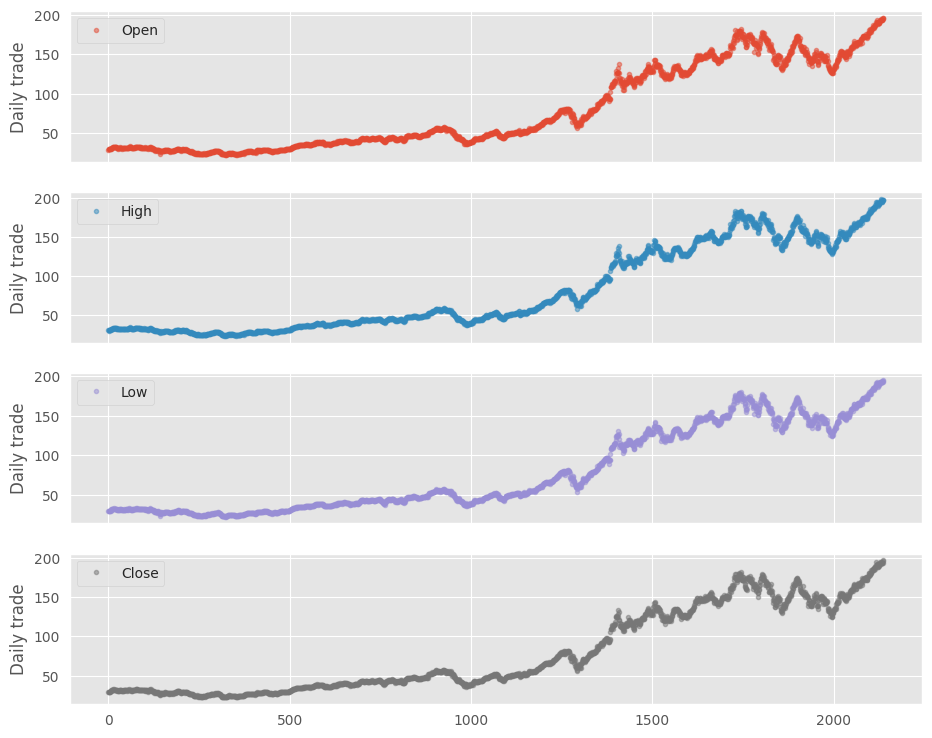

In [14]:
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

            Open        High         Low       Close   Adj Close     Volume  \
0      29.512501   29.792500   29.020000   29.657499   26.582630  250956400   
1      29.625000   29.772499   29.402500   29.662500   26.587107  207662800   
2      29.625000   30.127501   29.577499   29.889999   26.791023  280598800   
3      30.004999   30.057501   29.812500   29.985001   26.982241  168984800   
4      30.004999   30.062500   29.612499   29.732500   26.755026  174826400   
...          ...         ...         ...         ...         ...        ...   
2133  193.330002  194.440002  192.919998  193.619995  193.358887   37283200   
2134  193.669998  195.639999  193.320007  194.500000  194.237701   47471900   
2135  196.020004  197.199997  192.550003  193.220001  192.959427   47460200   
2136  194.669998  196.630005  194.139999  195.830002  195.565918   48291400   
2137  196.059998  196.490005  195.259995  196.449997  196.185074   38824100   

      MA for 10 days  MA for 50 days  MA for 100 da

,count,mean,std,min,25%,50%,75%,max
Open,2138.0,7.960419e+01,5.278595e+01,2.250000e+01,3.497188e+01,5.165750e+01,1.338150e+02,1.960600e+02
High,2138.0,8.050435e+01,5.344104e+01,2.291750e+01,3.525125e+01,5.216125e+01,1.350500e+02,1.982300e+02
Low,2138.0,7.876402e+01,5.218818e+01,2.236750e+01,3.480125e+01,5.109250e+01,1.321025e+02,1.952600e+02
Close,2138.0,7.967508e+01,5.284520e+01,2.258500e+01,3.502688e+01,5.180875e+01,1.336700e+02,1.964500e+02
Adj Close,2138.0,7.784060e+01,5.328670e+01,2.082606e+01,3.278217e+01,4.992889e+01,1.318052e+02,1.961851e+02
Volume,2138.0,1.258082e+08,6.650040e+07,3.145820e+07,8.154448e+07,1.081492e+08,1.501806e+08,6.488252e+08
MA for 10 days,2138.0,7.953760e+01,5.248669e+01,2.317750e+01,3.536425e+01,5.170163e+01,1.332968e+02,1.940270e+02
MA for 50 days,2138.0,7.895068e+01,5.100432e+01,2.393880e+01,3.654200e+01,5.226400e+01,1.307196e+02,1.857792e+02
MA for 100 days,2138.0,7.835399e+01,4.944935e+01,2.499158e+01,3.691574e+01,5.218409e+01,1.288267e+02,1.746826e+02
Daily Return,2138.0,1.056061e-03,1.848431e-02,-1.286470e-01,-7.520513e-03,7.764394e-04,1.031651e-02,1.198083e-01


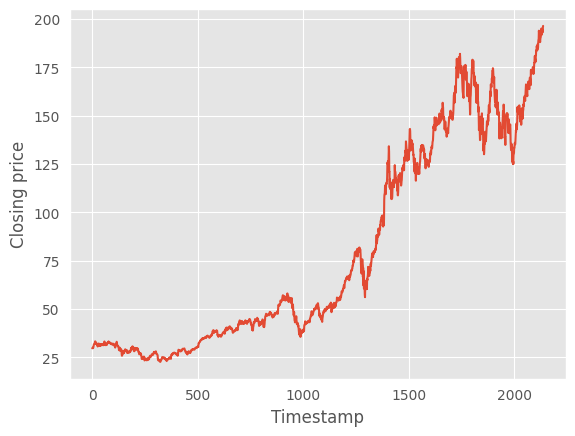

In [15]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

In [26]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA for 10 days',
       'MA for 50 days', 'MA for 100 days', 'Daily Return'],
      dtype='object')

In [30]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size = 100

# Assuming you want to use features from columns 2 to 5 (Open, High, Low, Close)
num_features = 9

for i in range(1, len(df) - window_size - 1, 1):
    first = df.iloc[i, 2]  # Assuming High is at column 2
    temp = []

    # Extract all features for the window
    for j in range(window_size):
        features = [(df.iloc[i + j, k] - first) / first for k in range(0, 9)]
        temp.extend(features)

    # Extract the target (Closing price)
    target = (df.iloc[i + window_size, 3] - first) / first  # Assuming Close is at column 3

    X.append(np.array(temp).reshape(100, num_features))
    Y.append(np.array(target).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

# Input shape should match the number of features
train_X = train_X.reshape(train_X.shape[0], 1, 100, num_features)
test_X = test_X.reshape(test_X.shape[0], 1, 100, num_features)

print(len(train_X))
print(len(test_X))


1628
408


In [31]:
model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

Epoch 1/40
41/41 [==============================] - 16s 103ms/step - loss: 0.0612 - mse: 0.0612 - mae: 0.1902 - val_loss: 0.0277 - val_mse: 0.0277 - val_mae: 0.1364
Epoch 2/40
41/41 [==============================] - 3s 76ms/step - loss: 0.0512 - mse: 0.0512 - mae: 0.1714 - val_loss: 0.0318 - val_mse: 0.0318 - val_mae: 0.1439
Epoch 3/40
41/41 [==============================] - 3s 75ms/step - loss: 0.0487 - mse: 0.0487 - mae: 0.1683 - val_loss: 0.0412 - val_mse: 0.0412 - val_mae: 0.1639
Epoch 4/40
41/41 [==============================] - 4s 93ms/step - loss: 0.0441 - mse: 0.0441 - mae: 0.1566 - val_loss: 0.0383 - val_mse: 0.0383 - val_mae: 0.1591
Epoch 5/40
41/41 [==============================] - 3s 77ms/step - loss: 0.0398 - mse: 0.0398 - mae: 0.1465 - val_loss: 0.0319 - val_mse: 0.0319 - val_mae: 0.1466
Epoch 6/40
41/41 [==============================] - 2s 48ms/step - loss: 0.0399 - mse: 0.0399 - mae: 0.1484 - val_loss: 0.0330 - val_mse: 0.0330 - val_mae: 0.1506
Epoch 7/40
41/41 [==

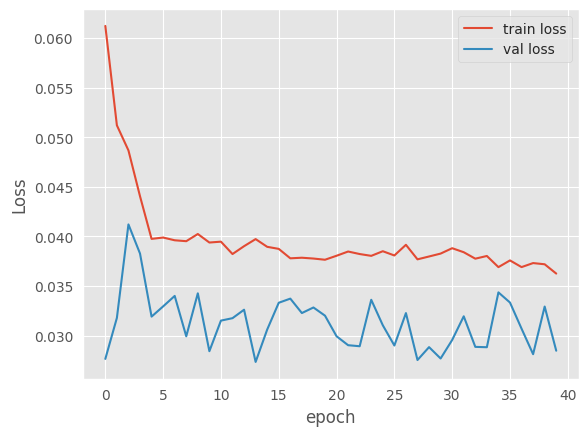

In [32]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

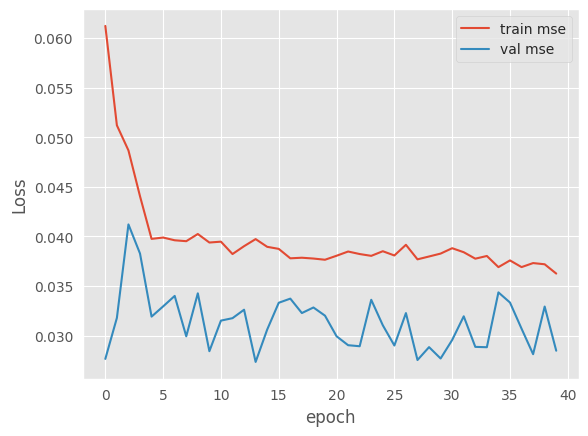

In [33]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

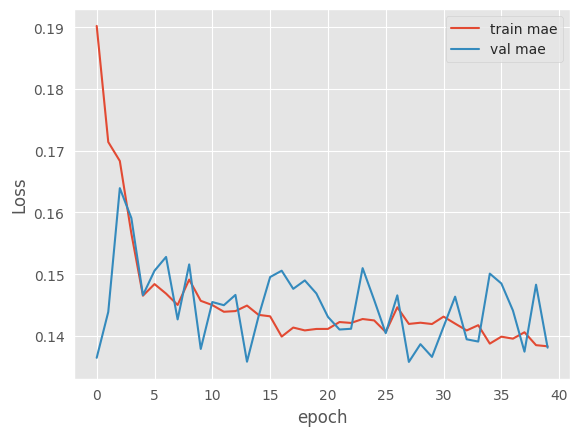

In [34]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDi  (None, 1, 98, 64)         1792      
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, 1, 49, 64)         0         
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 1, 47, 128)        24704     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 1, 23, 128)        0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 1, 21, 64)        

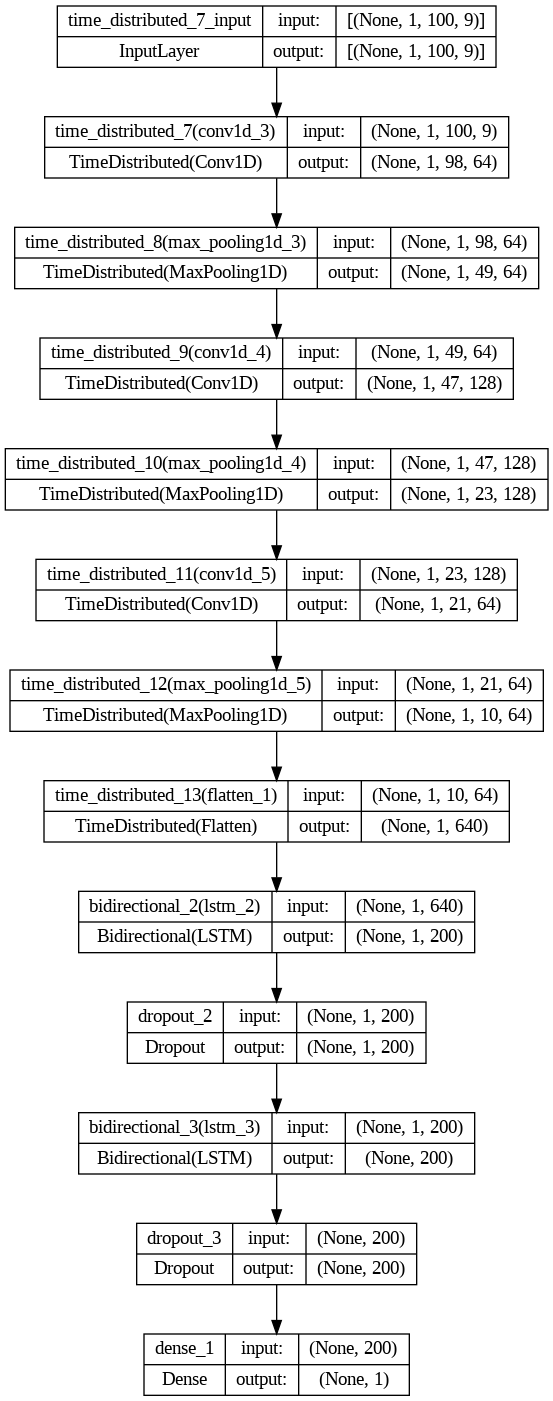

In [35]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [36]:
model.evaluate(test_X, test_Y)

13/13 [==============================] - 0s 12ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1381


[0.02848745882511139, 0.02848745882511139, 0.13808228075504303]

In [37]:
# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: -0.004504
R2 Score: -0.004504
Max Error: 0.383160


13/13 [==============================] - 0s 15ms/step


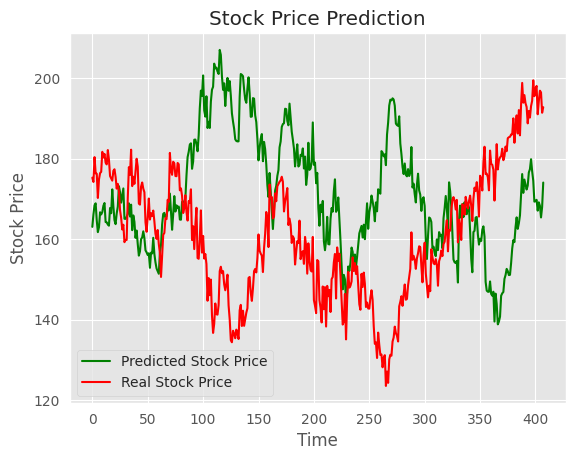

In [38]:
predicted = model.predict(test_X)
test_labels = test_Y.reshape(-1, 1)

# Rescaling all the features
for j in range(len(test_labels)):
    temp = data.iloc[len(train_X) + j, 3]  # Assuming Close is at column 3
    test_labels[j] = test_labels[j] * temp + temp
    predicted[j] = predicted[j] * temp + temp

plt.plot(predicted, color='green', label='Predicted Stock Price')
plt.plot(test_labels, color='red', label='Real Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
